## Principal Component Analysis. Part I: Correlation in 7-8 microns region 

In [484]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
import time
from matplotlib.pyplot import figure
import math as mt
from scipy import integrate
from math import isclose
time0 = time.perf_counter()

#### Navigating the cube
As shown in other codes, we navigate the MIRI cube and make the changes we think are needed for this analysis

In [485]:
spec_dir = 'data_products/'
channel = '2'  # 1 // 2 // 3 // 4 // all
band = 'short' # shor // medi // long // all
filesave = 'data/'
low = 1250
up= 1325
scale = 1e6*1e-26/((3.335641e-11)*1e4) # Changing to W/cm2 sr cm-1
scale = scale*1.1 # because of the oversized PSF of MIRIsim (REMOVE WITH REAL DATA)

filename= 'jupiter_ch4.res'
df = pd.read_csv(filename, sep='\s+', header = None)
df[0] = 10**4/df[0]
wavex = df[0]
spex = df[2]

if channel=='all':
    filename = spec_dir + 'allcube_ch1-2-3-4-mediumshortlong-_s3d.fits'
else:
    filename = spec_dir + 'Level3_ch' + str(channel) + '-' + str(band) + '_s3d.fits'
    
hdu = fits.open(filename)
hdr = hdu['SCI'].header
data = hdu['SCI'].data
RA = hdu['SCI'].header['RA_V1']
DEC = hdu['SCI'].header['DEC_V1']
CRPIX1 = hdu['SCI'].header['CRPIX1']
CRPIX2 = hdu['SCI'].header['CRPIX2']

ny = data.shape[1]
nx = data.shape[2]

if channel=='all':
    wave = hdu['WCS-TABLE'].data['wavelength'][0] #IF WORKING WITH 4 CHANNEL CUBE
else:    
    wave = np.arange(hdr['NAXIS3'])*hdr['CDELT3']+hdr['CRVAL3'] #IF WORKING WITH 1 CHANNEL or SUBBAND CUBE
    
wave = wave + 0.0033
wave = np.array(wave)
lenwave = int(len(wave))

wavenumber = 10**4/wave
for ix in range(len(wavenumber)):
            if wavenumber[ix] < low:
                lower = ix
                break
for iix in range(len(wavenumber)):
            if wavenumber[iix] < up:
                upper = iix
                break

#### Creating the emission line simple model

We create gaussian emission lines by defining sigma, mu and k. With that we create three modeled regions for the branches P, Q and R. After that we compare them with the spectra and check how the cube looks like.

We also integrate for specific intervals (vertical black dashed lines) every one of the lines modelled.

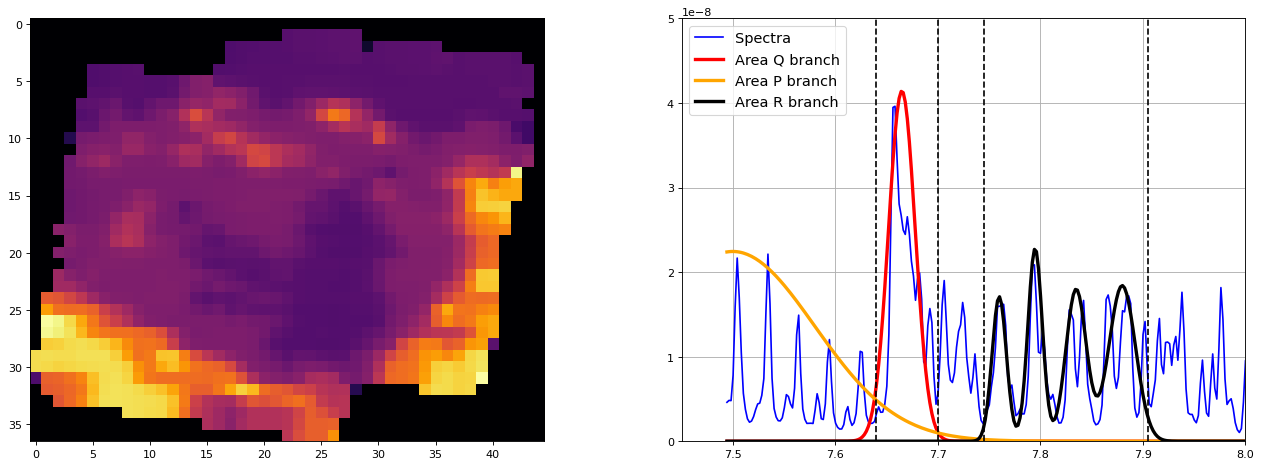

In [486]:
sigma = [0.013,0.08,0.007,0.007,0.01,0.013]
mu = [7.665,7.5,7.76,7.795, 7.835,7.88]
k = [1.35e-9,4.5e-9,3e-10,4e-10,4.5e-10,6e-10]
f = np.zeros([len(k), lenwave])

for i in range(len(k)):
        if i == 2:
            f[i,:] = k[i]/(sigma[i]*np.sqrt(2*np.pi))*np.exp(-(wave-mu[i])**2/(2*sigma[i]**2))+ \
            k[i+1]/(sigma[i+1]*np.sqrt(2*np.pi))*np.exp(-(wave-mu[i+1])**2/(2*sigma[i+1]**2))+ \
            k[i+2]/(sigma[i+2]*np.sqrt(2*np.pi))*np.exp(-(wave-mu[i+2])**2/(2*sigma[i+2]**2))+ \
            k[i+3]/(sigma[i+3]*np.sqrt(2*np.pi))*np.exp(-(wave-mu[i+3])**2/(2*sigma[i+3]**2))
        else:
            f[i,:] = k[i]/(sigma[i]*np.sqrt(2*np.pi))*np.exp(-(wave-mu[i])**2/(2*sigma[i]**2))

f = np.delete(f, [3,4,5], 0)
colors = ['red','orange','black']
    
figure(figsize=(20, 7), dpi=80)                
plt.subplot(1,2,1)
plt.imshow(data[100,:,:], cmap='inferno')
plt.subplot(1,2,2)
plt.plot(wave,data[:,20,20]*scale, color = 'blue')

for i in range(3):
    plt.plot(wave,f[i], color = colors[i], linewidth = 3)
    plt.xlim(7.45,8)
    plt.ylim(0,5e-8)
    plt.grid()
    
plt.legend(['Spectra','Area Q branch','Area P branch','Area R branch'], fontsize=13)    
plt.axvline(7.64, color='black', linestyle='--')
plt.axvline(7.7, color='black', linestyle='--')
plt.axvline(7.745, color='black', linestyle='--')   
plt.axvline(7.905, color='black', linestyle='--')  

intq = sum(f[0,73:105])
intp = sum(f[1,0:73])  
intr = sum(f[2,128:205]) 

We compare for every spaxel the relation between the observed spectra and the modeled gaussian, and get the correlation value rel for the three branches (P,Q and R) --> relp, relq and relr

In [487]:
intpx = np.zeros([ny, nx])
intqx = np.zeros([ny, nx])
intrx = np.zeros([ny, nx])
relp = np.zeros([ny, nx])
relq = np.zeros([ny, nx])
relr = np.zeros([ny, nx])

for i in range(ny):
    for ii in range(nx):
        spe = data[:,i,ii]
        spe = spe*scale
        intqx[i,ii] = sum(spe[0:73]) 
        intpx[i,ii] = sum(spe[73:105]) 
        intrx[i,ii] = sum(spe[128:205])

np.seterr(divide='ignore', invalid='ignore')   
relp = abs(intp/intpx)
relq = abs(intq/intqx)
relr = abs(intr/intrx)

We plot and see how the maps looks like. If the value of the spaxel is close to 1 means that the correlation is high.

Watch out! It is normal to obtain the least correlated values for the P band since it is not very well simulated (we only simulate the trend of the branch, not the emission lines).

Runtime of the extraction: 7.5 seconds
 
Saved in /home/povalle/notebook/extraction/data/


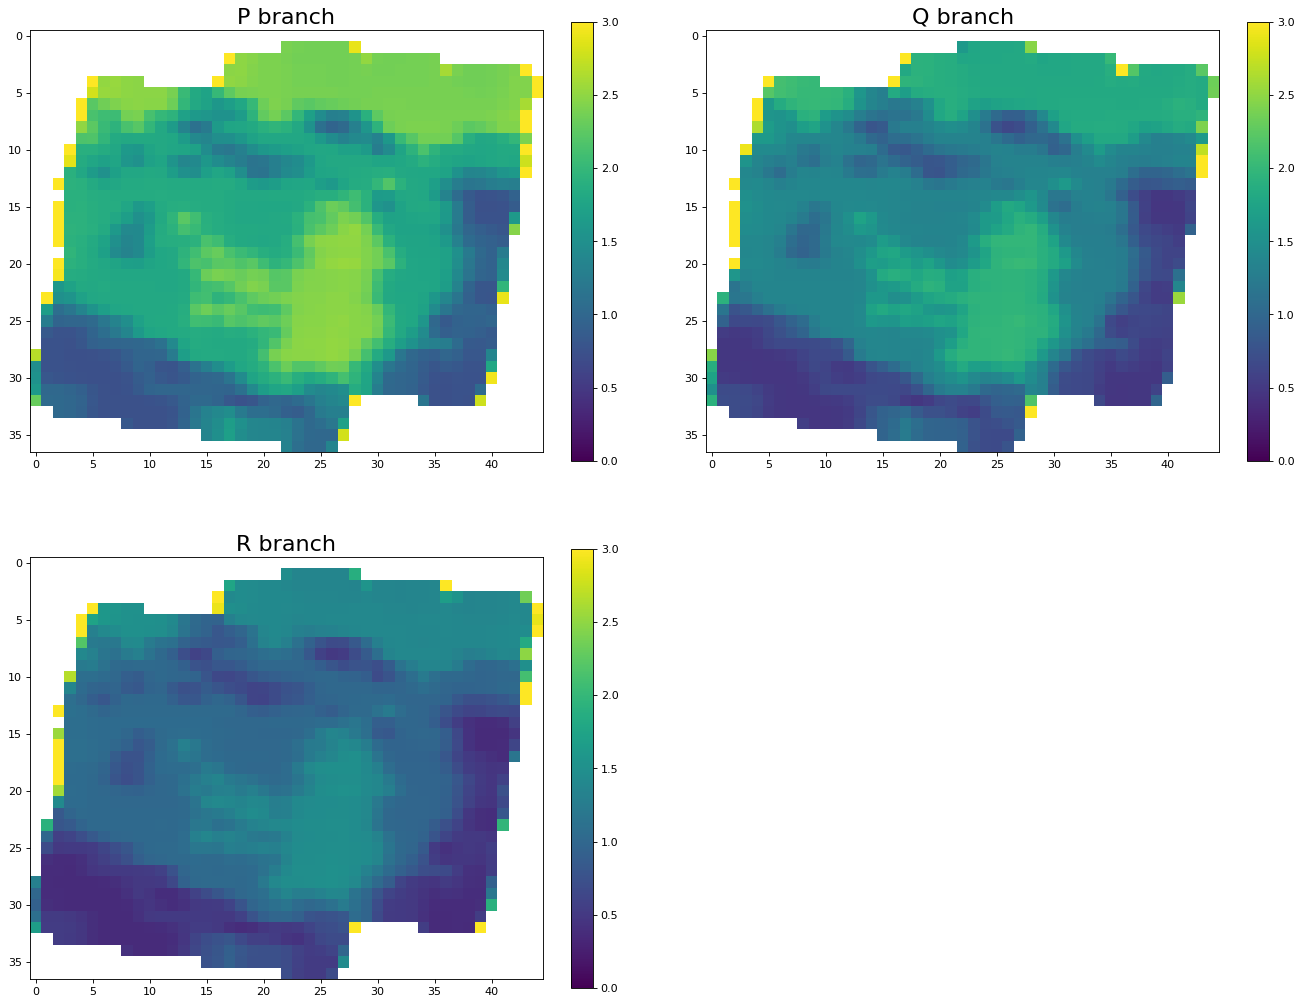

In [490]:
figure(figsize=(20, 16), dpi=80)  
plt.subplot(2,2,1)
plt.imshow(relp,vmin=0,vmax=3)
plt.title('P branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)
plt.subplot(2,2,2)
plt.imshow(relq,vmin=0,vmax=3)
plt.title('Q branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)
plt.subplot(2,2,3)
plt.imshow(relr,vmin=0,vmax=3)
plt.title('R branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)


#### Are they similar?

'isclose' outputs an binary value. In this case, if they are similar with a tolerance of the 10% of the value of the gaussian simple model we assume the spectra is similar and there is nothing weird.

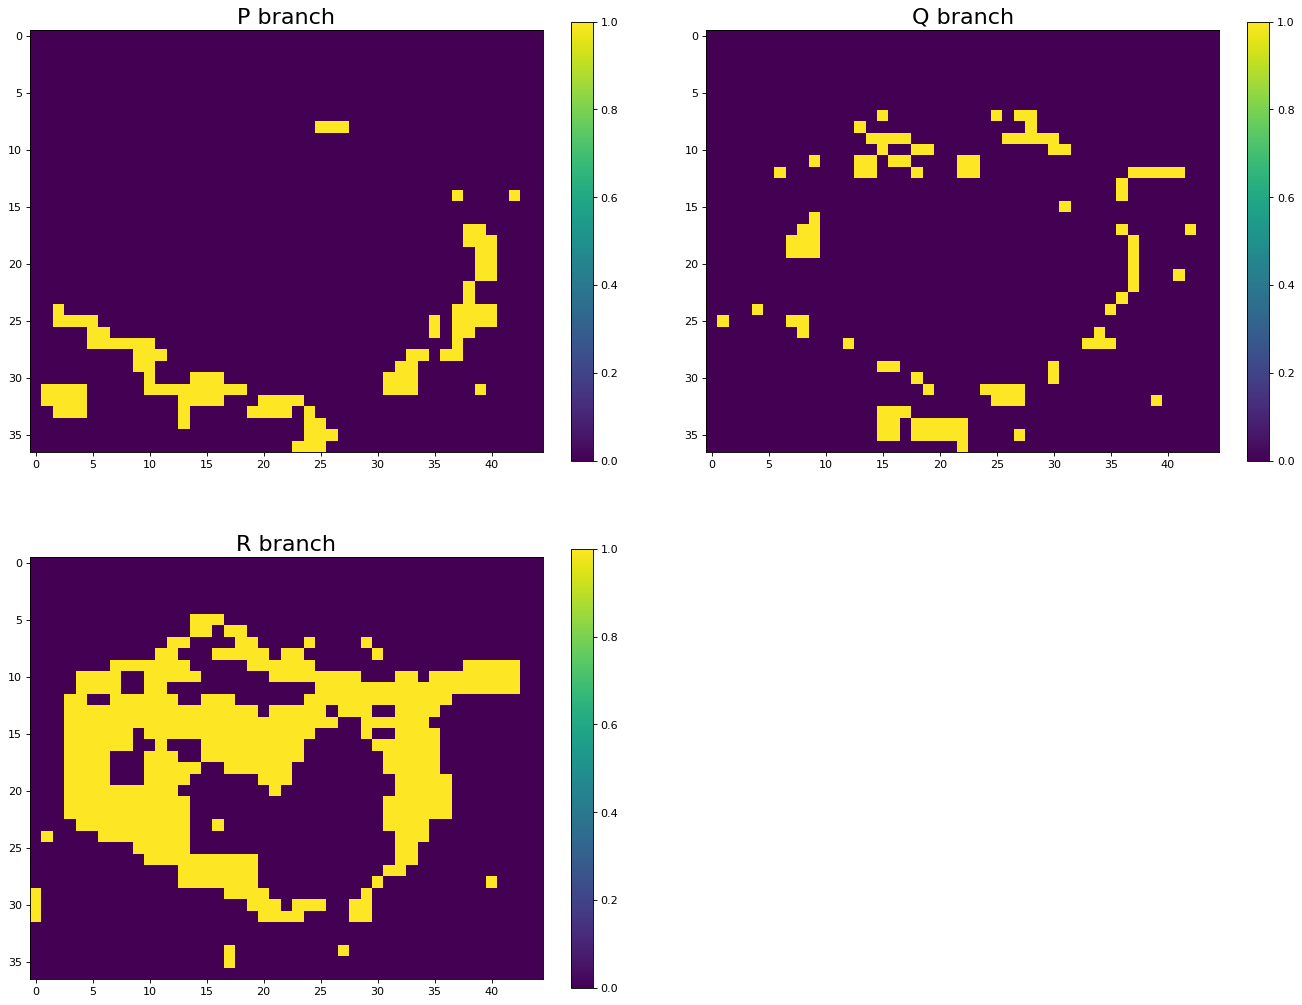

In [491]:
eqp = np.zeros([ny, nx])
eqq = np.zeros([ny, nx])
eqr = np.zeros([ny, nx])

for i in range(ny):
    for ii in range(nx):
        eqp[i,ii] = isclose(intp, intpx[i,ii], abs_tol=intp/10)
        eqq[i,ii] = isclose(intq, intqx[i,ii], abs_tol=intq/10)
        eqr[i,ii] = isclose(intr, intrx[i,ii], abs_tol=intr/10)

figure(figsize=(20, 16), dpi=80)  
plt.subplot(2,2,1)
plt.imshow(eqp)
plt.title('P branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)
plt.subplot(2,2,2)
plt.imshow(eqq)
plt.title('Q branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)
plt.subplot(2,2,3)
plt.imshow(eqr)
plt.title('R branch', fontsize=20)
plt.colorbar(fraction=0.04, pad=0.05)


time1 = time.perf_counter()
print(f"Runtime of the extraction: {time1 - time0:0.1f} seconds")